# Feature Engineering

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [2]:
df = pd.read_csv("Netflix1.csv")

In [3]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [4]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'type', 'rating'], inplace=True)


In [5]:
for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in df.select_dtypes(include='number'):
    df[col].fillna(df[col].median(), inplace=True)

In [6]:
df['duration_minutes'] = df['duration'].str.extract('(\d+)').astype(float)

In [7]:
df['num_genres'] = df['listed_in'].apply(lambda x: len(x.split(',')))

In [8]:
df['content_age'] = 2024 - df['date_added'].dt.year

In [9]:
df['release_day'] = df['date_added'].dt.day
df['release_month'] = df['date_added'].dt.month
df['release_year'] = df['date_added'].dt.year

# Recommendation System

## Content-Based Recommendation 

In [11]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['listed_in'].fillna(""))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [12]:
def recommend_content(title, df, cosine_sim):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    return df['title'].iloc[[i[0] for i in sim_scores]]

In [13]:
recommend_content("Inception", df, cosine_sim)

184          Chappie
205    Green Lantern
466          Beowulf
729    Mortal Kombat
742        Star Trek
Name: title, dtype: object

## Collaborative Filtering

In [14]:
df['user_id'] = df['title'].apply(lambda x: int(hashlib.sha256(x.encode()).hexdigest(), 16) % 1000)
df['movie_id'] = df['show_id'].str.extract('(\\d+)').fillna(0).astype(int)
df['rating_score'] = df['rating'].astype('category').cat.codes + 1

In [15]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating_score']], reader)
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.6177  3.5499  3.6111  3.5447  3.6392  3.5925  0.0381  
MAE (testset)     3.1684  3.1035  3.1712  3.1143  3.2321  3.1579  0.0461  
Fit time          0.22    0.22    0.22    0.22    0.22    0.22    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([3.61767875, 3.54990426, 3.61114757, 3.54469271, 3.63915629]),
 'test_mae': array([3.16837315, 3.10352673, 3.17121729, 3.11433447, 3.23208191]),
 'fit_time': (0.21673583984375,
  0.22391629219055176,
  0.22467422485351562,
  0.21635818481445312,
  0.22137856483459473),
 'test_time': (0.0200042724609375,
  0.017553329467773438,
  0.017003536224365234,
  0.01600337028503418,
  0.017554283142089844)}

In [16]:
def recommend_collaborative(user_id, df, model):
    all_movies = df['movie_id'].unique()
    predictions = [model.predict(user_id, movie_id) for movie_id in all_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_movies = [df[df['movie_id'] == pred.iid]['title'].values[0] for pred in predictions[:5]]
    return top_movies

In [17]:
recommend_collaborative(101, df, model)

['Dick Johnson Is Dead',
 'Ganglands',
 'Midnight Mass',
 'Confessions of an Invisible Girl',
 'Sankofa']

## Clustering with KMeans

In [18]:
pca = PCA(n_components=2)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

In [19]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(tfidf_reduced)
df['cluster'] = clusters

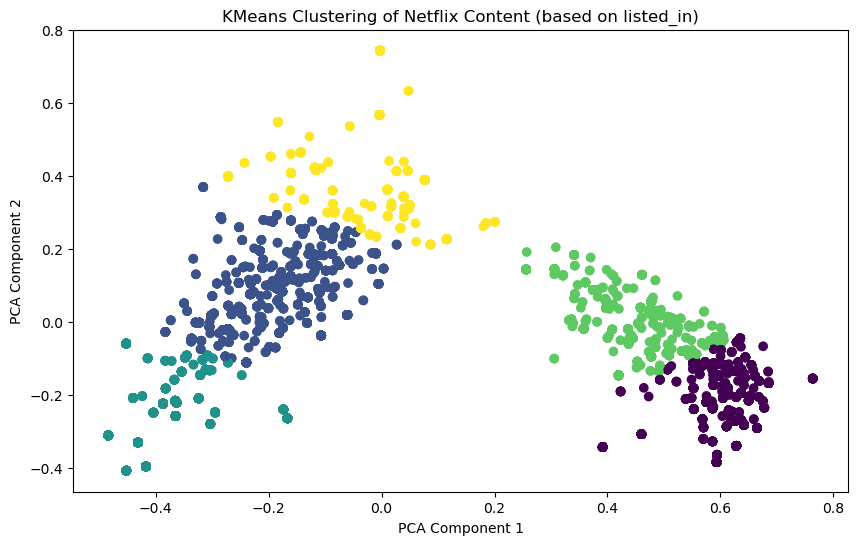

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(tfidf_reduced[:,0], tfidf_reduced[:,1], c=clusters, cmap='viridis')
plt.title("KMeans Clustering of Netflix Content (based on listed_in)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Classification - Predict Rating Label

In [21]:
features = df[['duration_minutes', 'num_genres', 'content_age']]
labels = df['rating']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [22]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [25]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred ,zero_division=1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           G       0.00      0.00      0.00        12
          NR       0.29      0.10      0.14        21
          PG       0.12      0.06      0.08        54
       PG-13       0.16      0.15      0.15        93
           R       0.28      0.25      0.26       155
       TV-14       0.34      0.34      0.34       444
        TV-G       0.08      0.05      0.06        44
       TV-MA       0.43      0.57      0.49       628
       TV-PG       0.16      0.09      0.12       181
        TV-Y       0.39      0.29      0.33        66
       TV-Y7       0.22      0.20      0.21        59
          UR       1.00      0.00      0.00         1

    accuracy                           0.35      1758
   macro avg       0.29      0.17      0.18      1758
weighted avg       0.32      0.35      0.33      1758


Confusion Matrix:
[[  0   0   0   0   1   0   0  10   0   1   0   0]
 [  0   2   1   0   2   4   1   9   1  